In [1]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.sparse as sp
from scipy.stats import linregress
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.gosubdag.gosubdag import GoSubDag
import requests
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
import random

from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

from typing import List, Dict, Tuple, Set, Any, Optional, Union

import networkx as nx

from vocabulary_functions import get_mutated, get_parents, set_difference, set_intersection, load_tokenizers, calc_agreement, calc_dice_idx_only

In [2]:
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# Download GO DAG (ontology structure)
obo_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"

# Download OBO file if not already downloaded
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)

# Parse GO DAG
go_dag = GODag(obo_path)

# Download GO Slim generic terms
goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"

if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)

# Parse GO Slim DAG
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())

go_subdag_slim = GoSubDag(goslim_terms, go_dag)

goslim_id2name = {go_id : go_dag[go_id].name for go_id in goslim_terms}
goslim_name2id = {go_dag[go_id].name : go_id for go_id in goslim_terms}

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


In [4]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
vocab_sizes = [6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    # {
    #     'is_mut': True,
    #     'dataset': f'uniref{uniref_id}',
    #     'is_pretokenizer': False,
    #     'subs_matrix': 'pam70',
    #     'mutation_cutoff': 0.7,
    #     'min_mutation_freq': 0.05,
    #     'min_mutation_len': 3,
    #     'max_mutation_len': 12,
    #     'vocab_size': vocab_sizes
    # },
    # {
    #     'is_mut': True,
    #     'dataset': f'uniref{uniref_id}',
    #     'is_pretokenizer': True,
    #     'subs_matrix': 'blosum62',
    #     'mutation_cutoff': 0.7,
    #     'min_mutation_freq': 0.05,
    #     'min_mutation_len': 3,
    #     'max_mutation_len': 12,
    #     'vocab_size': vocab_sizes
    # },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

In [5]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))

In [6]:
methods = [method_name[:-len(str(vocab_sizes[0]))-1] for method_name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn:mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}
methods2names

{'BPE': 'BPE',
 'PUMA blosum62 0.7 0.05': 'PUMA BLOSUM62 0.7 0.05',
 'PUMA pre pam70 0.7 0.05': 'PUMA Pre PAM70 0.7 0.05'}

In [7]:
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    template_dict = {
        
    }
    vocab_lineage_list[k] = {token:{
                                'frequency': -1,
                                'order': -1,
                                'parent_pair': [],
                                'parent_mutation': "",
                                'parent_mutation_similarity': -1,
                                'partner_pair_self': False,
                                'partner_pair_left': [],
                                'partner_pair_right': [],
                                'child_pair': [],
                                'child_mutation': []
                            } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items()):
    for token, inner_vocab_elements in vocab.items():
        vocab_lineage_list[method_name][token]['frequency'] = inner_vocab_elements['frequency']
        vocab_lineage_list[method_name][token]['order'] = inner_vocab_elements['order']
        vocab_lineage_list[method_name][token]['parent_pair'] = inner_vocab_elements['pair'] if 'pair' in inner_vocab_elements else []
        vocab_lineage_list[method_name][token]['parent_mutation'] = inner_vocab_elements['parent'] if 'parent' in inner_vocab_elements else ""
        vocab_lineage_list[method_name][token]['parent_mutation_similarity'] = inner_vocab_elements['similarity'] if 'similarity' in inner_vocab_elements else -1

        if 'pair' in inner_vocab_elements:
            if inner_vocab_elements['pair'][0] == inner_vocab_elements['pair'][1]:
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][0]]['partner_pair_self'] = True
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][0]]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][0]]['partner_pair_right'].append(inner_vocab_elements['pair'][1])
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][1]]['partner_pair_left'].append(inner_vocab_elements['pair'][0])
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][0]]['child_pair'].append(token)
                vocab_lineage_list[method_name][inner_vocab_elements['pair'][1]]['child_pair'].append(token)
        if 'parent' in inner_vocab_elements:
                vocab_lineage_list[method_name][inner_vocab_elements['parent']]['child_mutation'].append(token)

100%|██████████| 9/9 [00:00<00:00, 46.85it/s]


In [8]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'RCA', 'TAS', 'IEA']
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental+go_evidence_computational)].reset_index(drop=True)

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo['go_slim_id'] = df_quickgo['go_slim_id'].apply(lambda x: x[0] if len(x) > 0 else '')
df_quickgo = df_quickgo[df_quickgo['go_slim_id'] != '']

# Drop duplicates
# df_quickgo = df_quickgo.drop_duplicates(subset=['uniprot_id', 'go_slim_id']).drop(columns=['go_id', 'go_evidence']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).count().reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id', 'go_evidence']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# # Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts()>20].index)].reset_index(drop=True)

conn.close()

In [9]:
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)
df_quickgo

,uniprot_id,go_id,go_name,go_aspect
0,X6RLR1,GO:0000910,cytokinesis,biological_process
1,X6RLR1,GO:0005730,nucleolus,cellular_component
2,X6RLR1,GO:0005829,cytosol,cellular_component
3,X6RLN4,GO:0005829,cytosol,cellular_component
4,X6RL45,GO:0016787,hydrolase activity,molecular_function
...,...,...,...,...
144322,A0A024CHX5,GO:0016787,hydrolase activity,molecular_function
144323,A0A024CHX5,GO:0005576,extracellular region,cellular_component
144324,A0A023T4H3,GO:0140096,"catalytic activity, acting on a protein",molecular_function
144325,A0A023IQH3,GO:0007155,cell adhesion,biological_process


In [10]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    53188
biological_process    46533
molecular_function    44606
Name: count, dtype: int64

In [11]:
df_quickgo['go_name'].value_counts()

go_name
nucleus                                    9249
plasma membrane                            6163
cytosol                                    6135
nucleoplasm                                5385
catalytic activity, acting on a protein    5348
                                           ... 
cell adhesion mediator activity              41
peroxisome organization                      35
respiratory system process                   33
cytoplasmic translation                      32
cyclase activity                             30
Name: count, Length: 126, dtype: int64

In [12]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


In [13]:
df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein

,uniprot_id,sequence,BPE 6400,BPE 12800,BPE 25600,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600,PUMA pre pam70 0.7 0.05 6400,PUMA pre pam70 0.7 0.05 12800,PUMA pre pam70 0.7 0.05 25600
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[MEL, SA, EYL, REKL, QR, DLEA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EAEH, VL, PSP, GG, ...","[MEL, SA, EYL, REKL, QRDL, EAEH, VL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,..."
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, TFA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FR, RL, TFA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FRRL, TFA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, TFA, QLL, FA, TVL, GIA, GGV, YI, F...","[M, FRRL, TFA, QLL, FA, TVL, GIA, GGV, YI, FQ,...","[M, FRRL, TFA, QLL, FA, TVL, GIA, GGV, YI, FQ,..."
4,A0A0C5B5G6,MRWQEMGYIFYPRKLR,"[MR, W, QE, MG, YI, FY, PR, KL, R]","[MRW, QE, MG, YI, FY, PRKL, R]","[MRW, QE, MG, YI, FY, PRKL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QEMG, YI, FY, PRKL, R]","[MRW, QEMG, YI, FY, PRKL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PRKL, R]"
...,...,...,...,...,...,...,...,...,...,...,...
70687,X6RL83,MLQEWLAAVGDDYAAVVWRPEGEPRFYPDEEGPKHWTKERHQFLME...,"[ML, QE, WL, AAVG, DDY, AAVV, W, RP, EG, EPR, ...","[ML, QE, WL, AAVG, DDY, AAVV, W, RPEG, EPR, FY...","[ML, QE, WL, AAVG, DDY, AAVV, W, RPEG, EPR, FY...","[ML, QE, WL, AAVG, DDY, AA, VV, W, RP, EG, EPR...","[ML, QE, WL, AAVG, DDY, AA, VVW, RPEG, EPR, FY...","[ML, QE, WL, AAVG, DDY, AA, VVW, RPEG, EPR, FY...","[M, L, QE, WL, AAVG, DD, YAA, VV, W, RP, EG, E...","[M, L, QE, WL, AAVG, DD, YAA, VV, W, RP, EG, E...","[M, L, QE, WL, AAVG, DD, YAA, VV, W, RPEG, EPR..."
70688,X6RLN4,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SNW...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ..."
70689,X6RLR1,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...","[MA, GLT, DL, QRL, QARV, EELER, WV,

In [15]:
df_protein_go = pd.merge(df_protein, df_quickgo, how='inner', on='uniprot_id')[['uniprot_id', 'go_id', 'go_name', 'go_aspect']+list(df_protein.columns[1:])].reset_index(drop=True)
df_protein_go

,uniprot_id,go_id,go_name,go_aspect,sequence,BPE 6400,BPE 12800,BPE 25600,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600,PUMA pre pam70 0.7 0.05 6400,PUMA pre pam70 0.7 0.05 12800,PUMA pre pam70 0.7 0.05 25600
0,A0A087X1C5,GO:0016491,oxidoreductase activity,molecular_function,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,..."
1,A0A087X1C5,GO:0005739,mitochondrion,cellular_component,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,..."
2,A0A087X296,GO:0006629,lipid metabolic process,biological_process,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
3,A0A087X296,GO:0016491,oxidoreductase activity,molecular_function,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
4,A0A087X296,GO:0005783,endoplasmic reticulum,cellular_component,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144322,X6RL45,GO:0016787,hydrolase activity,molecular_function,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,"[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CA,...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CAQ...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PD, PATI, EG, CA,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TIEG, CA, Q..."
144323,X6RLN4,GO:0005829,cytosol,cellular_component,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN,

In [336]:
# Protein unitlerini "doküman" formatına dönüştürme
def create_unit_documents(df: pd.DataFrame, tokenizer_col: str, token_len_thr: int = 0) -> List[str]:
    """Her protein için tokenizer çıktılarını boşluklarla ayrılmış doküman formatına dönüştürür"""
    # return df[tokenizer_col].apply(lambda units: ' '.join(units)).tolist()
    return df[tokenizer_col].apply(lambda units: ' '.join(unit for unit in units if len(unit) >= token_len_thr)).tolist()

# GO terimlerini etiketlere dönüştürme
def create_go_labels(df: pd.DataFrame, go_col: str = 'go_id') -> List[List[str]]:
    """Her protein için GO terimlerini liste formatında döndürür"""
    return df[go_col].tolist()

# BERTopic modeli oluşturma
def create_bertopic_model(documents: List[str], go_labels: List[str], token_len_thr: int = 0) -> Tuple[BERTopic, np.ndarray]:
    """Manuel topic modelleme için BERTopic modeli oluşturur"""
    
    # GO terimleri için one-hot encoding
    lb = LabelBinarizer()
    go_binary = lb.fit_transform(go_labels)
    
    # CountVectorizer ayarları - protein unit'ler için
    vectorizer_model = CountVectorizer(
        lowercase=False,
        token_pattern=r"(?u)\b\w{%d,}\b" %token_len_thr,
        stop_words=None,  # Protein unit'lerde stop word kullanmıyoruz
        ngram_range=(1, 1),  # Tek ve çift protein unit'leri de değerlendirelim
        min_df=5,  # En az 5 proteinde görünen unit'leri alalım
        max_df=0.7,  # Proteinlerin %70'inden fazlasında görünenleri çıkaralım
    )
    
    # Protein unit'lerin önemi için özel TF-IDF
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    
    # Terimlerin temsil edilmesi için model
    representation_model = KeyBERTInspired()
    
    empty_embedding_model = BaseEmbedder()
    empty_dimensionality_model = BaseDimensionalityReduction()
    empty_cluster_model = BaseCluster()

    # BERTopic model oluşturma - embedding modeli belirtmiyoruz (manuel topic modelleme)
    topic_model = BERTopic(
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        embedding_model=empty_embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        # representation_model=representation_model,
        # min_topic_size=10,  # En az 10 protein içeren topic'leri kabul edelim
        # calculate_probabilities=True,
        verbose=False
    )
    
    # Topic'leri manuel olarak GO terimleriyle eşleştir
    topics = np.argmax(go_binary, axis=1)
    
    # Eğer bir protein için hiçbir GO terimi yoksa, -1 (outlier) olarak işaretle
    topics[np.sum(go_binary, axis=1) == 0] = -1
    
    # Topic isimlerini go_slim_ids değerleriyle eşleştir
    topic_labels = {i: lb.classes_[i] for i in range(len(lb.classes_))}
    topic_labels[-1] = "Outlier"  # Outlier topic'i için etiket
    
    # Belgeleri ve topic'leri kullanarak modeli eğit
    topic_model.fit_transform(documents, y=topics)
    topic_model.set_topic_labels(topic_labels)
    
    return topic_model, topics

In [350]:
def compute_smoothing_matrix(similarity_matrix, lambda_smooth=0.1):
        """Precompute the smoothing matrix (I + λA)"""
        # Normalize adjacency matrix (row-wise normalization)
        if similarity_matrix is None or similarity_matrix.sum() == 0:
            return None
        
        A = similarity_matrix.copy()
        row_sums = np.array(A.sum(axis=1)).flatten()
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        A_norm = A / row_sums[:, np.newaxis]
        
        # Create smoothing matrix: (I + λA)
        I = np.eye(A_norm.shape[0])
        smoothing_matrix = I + lambda_smooth * A_norm
        
        return smoothing_matrix

def apply_graph_smoothing(X, smoothing_matrix):
    """
    Apply graph smoothing to document-term matrix before c-TF-IDF
    
    Args:
        X: Document-term matrix (n_documents x n_features)
        similarity_matrix: Unit similarity matrix (n_features x n_features)
        lambda_smooth: Smoothing parameter
        
    Returns:
        Smoothed document-term matrix
    """
    if smoothing_matrix is None:
        return X
    
    # Apply smoothing: D' = D * (I + λA)
    if sp.issparse(X):
        X_smoothed = X.dot(sp.csr_matrix(smoothing_matrix))
    else:
        X_smoothed = np.dot(X, smoothing_matrix)
        
    return X_smoothed


class GraphAwareCountVectorizer(CountVectorizer):
    """CountVectorizer that applies graph smoothing to the resulting matrix"""
    
    def __init__(self, 
                 similarity_matrix=None,
                 lambda_smooth=0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.lambda_smooth = lambda_smooth
        self.similarity_matrix = similarity_matrix
        self.smoothing_matrix = None
    
    def fit_transform(self, raw_documents, y=None):
        """Fit and transform with graph smoothing"""
        X = super().fit_transform(raw_documents, y)

        self.smoothing_matrix = compute_smoothing_matrix(self.similarity_matrix, self.lambda_smooth)
        
        # Apply graph smoothing if similarity matrix is available
        if self.smoothing_matrix is not None:
            # print('fit_transform', X.shape, self.smoothing_matrix.shape)
            X = apply_graph_smoothing(X, self.smoothing_matrix)
            
        return X
    
    def transform(self, raw_documents):
        """Transform with graph smoothing"""
        X = super().transform(raw_documents)
        # print('transform', X.shape, self.smoothing_matrix.shape)
        
        # Apply graph smoothing if similarity matrix is available
        if self.smoothing_matrix is not None:
            X = apply_graph_smoothing(X, self.smoothing_matrix)
            
        return X



def build_unit_similarity_matrix(unit_relationships: Dict[str, Dict], 
                                vocabulary: List[str],
                                alpha: float = 1.0, 
                                beta: float = 0.5,
                                theta: float = 0.7) -> np.ndarray:
    """
    Build adjacency matrix for protein unit relationships
    
    Args:
        unit_relationships: Dictionary containing unit relationships
            Expected format:
            {
                'hierarchical': {
                    'parent_unit': ['child1', 'child2', ...],
                    ...
                },
                'mutational': {
                    'parent1': ['child1', 'child2', ...],
                    'parent2': ['child1', 'child2', ...],
                    ...
                }
            }
        vocabulary: List of all protein units (vocabulary from CountVectorizer)
        alpha: Weight for merge parent-child relationships
        beta: Weight for sibling relationships
        theta: Weight for mutation parent-child relationships
        
    Returns:
        Adjacency matrix (n_units x n_units)
    """
    
    # Create unit to index mapping
    unit_to_idx = {unit: idx for idx, unit in enumerate(vocabulary)}
    n_units = len(vocabulary)
    
    # Initialize adjacency matrix
    A = np.zeros((n_units, n_units))
    
    # Add hierarchical relationships (parent-child)
    if 'hierarchical' in unit_relationships:
        for parent, children in unit_relationships['hierarchical'].items():
            if parent in unit_to_idx:
                parent_idx = unit_to_idx[parent]
                for child in children:
                    if child in unit_to_idx:
                        child_idx = unit_to_idx[child]
                        # Bidirectional parent-child relationship
                        A[parent_idx, child_idx] = alpha
                        A[child_idx, parent_idx] = alpha
    
    # Add mutational relationships (family-based)
    if 'mutational' in unit_relationships:
        for parent, children in unit_relationships['mutational'].items():
            if parent in unit_to_idx:
                parent_idx = unit_to_idx[parent]
                for i in range(len(children)):
                    if children[i] in unit_to_idx:
                        child_i_idx = unit_to_idx[children[i]]
                        # Parent-child relationship
                        A[parent_idx, child_i_idx] = theta
                        A[child_i_idx, parent_idx] = theta
                        for j in range(i+1, len(children)):
                            if children[j] in unit_to_idx:
                                child_j_idx = unit_to_idx[children[j]]
                                # Sibling relationship
                                A[child_i_idx, child_j_idx] = beta
                                A[child_j_idx, child_i_idx] = beta
    
    return A


def create_graph_aware_bertopic_model(documents: List[str], 
                                    go_labels: List[str],
                                    unit_relationships: Optional[Dict[str, Dict]] = None,
                                    token_len_thr: int = 0,
                                    lambda_smooth: float = 0.1,
                                    alpha: float = 1.0,
                                    beta: float = 0.5,
                                    theta: float = 0.7) -> Tuple[BERTopic, np.ndarray, np.ndarray]:
    """
    Create Graph-Aware BERTopic model for protein analysis
    
    Args:
        documents: List of protein sequences (tokenized with protein units)
        go_labels: List of GO-slim labels for each protein
        unit_relationships: Dictionary containing unit relationships (hierarchical & mutational)
        token_len_thr: Minimum token length threshold
        lambda_smooth: Graph smoothing parameter
        alpha: Weight for parent-child relationships
        beta: Weight for sibling relationships
        theta: Weight for mutation parent-child relationships
        
    Returns:
        Tuple of (BERTopic model, topics array, similarity matrix)
    """
    
    # GO terms için one-hot encoding
    lb = LabelBinarizer()
    go_binary = lb.fit_transform(go_labels)
    
    # CountVectorizer ayarları - protein units için
    # temp_vectorizer = CountVectorizer(
    #     lowercase=False,
    #     token_pattern=r"(?u)\b\w{%d,}\b" % token_len_thr,
    #     stop_words=None,
    #     ngram_range=(1, 1),
    #     min_df=5,
    #     max_df=0.7,
    # )
    
    # temp_vectorizer.fit(documents)
    # vocabulary = temp_vectorizer.get_feature_names_out().tolist()
    # vocabulary = temp_vectorizer.vocabulary_ 

    temp_topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr)
    vocabulary = temp_topic_model.get_params()['vectorizer_model'].vocabulary_

    # Build unit similarity matrix
    similarity_matrix = None
    if unit_relationships is not None:
        similarity_matrix = build_unit_similarity_matrix(
            unit_relationships=unit_relationships,
            vocabulary=vocabulary,
            alpha=alpha,
            beta=beta,
            theta=theta
        )
        print(f"Built similarity matrix with shape: {similarity_matrix.shape}")
        print(f"Non-zero edges: {np.sum(similarity_matrix > 0)}")
    
    # Create graph-aware CountVectorizer
    vectorizer_model = GraphAwareCountVectorizer(
        similarity_matrix=similarity_matrix,
        lambda_smooth=lambda_smooth,
        lowercase=False,
        token_pattern=r"(?u)\b\w{%d,}\b" % token_len_thr,
        stop_words=None,
        ngram_range=(1, 1),
        vocabulary=vocabulary  # Use the same vocabulary
    )
    
    # Standard c-TF-IDF model (no need for custom one now)
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    
    # Representation model
    representation_model = KeyBERTInspired()
    
    # Empty models for manual topic assignment
    empty_embedding_model = BaseEmbedder()
    empty_dimensionality_model = BaseDimensionalityReduction()
    empty_cluster_model = BaseCluster()
    
    # BERTopic model with graph-aware c-TF-IDF
    topic_model = BERTopic(
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        embedding_model=empty_embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        # representation_model=representation_model,
        # min_topic_size=10,  # En az 10 protein içeren topic'leri kabul edelim
        # calculate_probabilities=True,
        verbose=False
    )
    
    # Manual topic assignment based on GO terms
    topics = np.argmax(go_binary, axis=1)
    
    # Mark proteins without GO terms as outliers
    topics[np.sum(go_binary, axis=1) == 0] = -1
    
    # Create topic labels
    topic_labels = {i: lb.classes_[i] for i in range(len(lb.classes_))}
    topic_labels[-1] = "Outlier"
    
    # Train the model
    topic_model.fit_transform(documents, y=topics)
    topic_model.set_topic_labels(topic_labels)
    
    print(f"Model trained with {len(set(topics))} topics")
    print(f"Graph smoothing parameter λ = {lambda_smooth}")
    
    return topic_model, topics, similarity_matrix


In [340]:
def split_data(df, test_size=0.2, random_state=42):
    # Tüm benzersiz UniProt ID'leri al
    unique_uniprot_ids = df["uniprot_id"].unique().tolist()
    random.shuffle(unique_uniprot_ids)

    # ID'lerin %80-%20 şeklinde split edilmesi
    train_ids, test_ids = train_test_split(unique_uniprot_ids, test_size=test_size, random_state=random_state)

    # Verileri splitlere ayır
    df_train = df[df["uniprot_id"].isin(train_ids)].copy()
    df_test = df[df["uniprot_id"].isin(test_ids)].copy()

    # GO dağılımlarını kontrol et
    def go_dist(data):
        return data['go_id'].value_counts(normalize=True)

    train_dist = go_dist(df_train)
    test_dist = go_dist(df_test)

    # Dağılım farklarını görmek için karşılaştıralım
    distribution_df = pd.DataFrame({
        "train_ratio": train_dist,
        "test_ratio": test_dist
    }).fillna(0)

    distribution_df["difference"] = abs(distribution_df["train_ratio"] - distribution_df["test_ratio"])

    # Gerekirse tolerans üstü farkları göster
    print(distribution_df.sort_values("difference", ascending=False).head(5))
    print()

    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)


In [341]:
def evaluate_go_term_representations(df_test: pd.DataFrame, topic_model: BERTopic, tokenizer_col: str, go_col: str = 'go_name', scoring_type: str = 'exist') -> Dict[str, Any]:
    """
    Evaluates the learned GO term representations on the test set using various metrics.
    This version is optimized for speed and includes per-GO-term metrics and frequency-based scoring.

    Args:
        df_test: The test dataframe containing protein sequences and their true GO terms.
        topic_model: The trained BERTopic model.
        tokenizer_col: The name of the column in df_test with the tokenized sequences.
        go_col: The name of the column in df_test with the true GO term labels.

    Returns:
        A dictionary containing the evaluation results.
    """
    
    # --- Step 1: Pre-process topic representations for faster lookup ---
    go_term_representations = {}
    topic_info = topic_model.get_topic_info()
    topic_id_to_go_name = {row.Topic: row.CustomName for _, row in topic_info.iterrows()}

    for topic_id, go_name in topic_id_to_go_name.items():
        if topic_id == -1:
            continue
        representation = topic_model.get_topic(topic_id)
        if representation:
            go_term_representations[go_name] = {unit: score for unit, score in representation}

    # --- Step 2: Iterate through the test set to get predictions and scores ---
    y_true = []
    all_sorted_predictions = []
    reciprocal_ranks = []
    
    test_proteins = df_test.groupby('uniprot_id')

    for uniprot_id, protein_data in tqdm(test_proteins, desc="Evaluating Test Set"):
        true_go_name = protein_data.iloc[0][go_col]
        
        # Use a Counter to get frequencies of each unit for the new scoring metric.
        tokenized_sequence = protein_data.iloc[0][tokenizer_col]
        if not tokenized_sequence:
            continue
        token_counts = Counter(tokenized_sequence)

        # --- Step 3: Score all possible GO terms for the current protein ---
        if scoring_type == 'freq':
            # New Metric: Score is the sum of (unit_score * unit_frequency_in_protein)
            go_scores = {go_name: sum(unit_score * token_counts.get(unit, 0) for unit, unit_score in representation.items()) for go_name, representation in go_term_representations.items()}
        else:
            # Sum the scores of representative units that are present in the protein's sequence
            go_scores = {go_name: sum(unit_score for unit, unit_score in representation.items() if unit in tokenized_sequence) for go_name, representation in go_term_representations.items()}
            
        if not go_scores:
            continue

        # Sort GO terms by their calculated score in descending order
        sorted_go_terms = sorted(go_scores.items(), key=lambda item: item[1], reverse=True)
        
        # Store the full sorted list of predictions for efficient top-k calculation later
        sorted_prediction_names = [go_name for go_name, score in sorted_go_terms]
        all_sorted_predictions.append(sorted_prediction_names)
        y_true.append(true_go_name)
        
        # --- Step 4: Calculate rank of the true GO term for MRR ---
        try:
            rank = sorted_prediction_names.index(true_go_name) + 1
            reciprocal_ranks.append(1.0 / rank)
        except ValueError:
            # The true GO term was not in the list of predictions
            reciprocal_ranks.append(0.0)

    # --- Step 5: Calculate and compile final metrics ---
    results = {}
    
    if not y_true:
        return {"error": "No test data to evaluate."}

    # --- Metric: Top-k Accuracy (Optimized) ---
    # Calculates the percentage of times the true GO term is in the top k predictions.
    top_k_accuracies = {}
    for k in [1, 3, 5, 10]:
        correct_predictions = sum(1 for i, true_label in enumerate(y_true) if true_label in all_sorted_predictions[i][:k])
        top_k_accuracies[f'accuracy_at_{k}'] = correct_predictions / len(y_true)
    
    results['top_k_accuracy'] = top_k_accuracies
    
    # --- Metric: Mean Reciprocal Rank (MRR) ---
    # The average of the reciprocal ranks of the correct GO term.
    results['mean_reciprocal_rank'] = np.mean(reciprocal_ranks) if reciprocal_ranks else 0

    # --- Metric: Classification Report (Precision, Recall, F1-Score) ---
    # Based on the top-1 prediction (the GO term with the highest weighted score).
    y_pred = [preds[0] if preds else None for preds in all_sorted_predictions]
    
    # Filter out None predictions if any protein had no scoreable GO terms
    valid_indices = [i for i, p in enumerate(y_pred) if p is not None]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    if y_true_filtered and y_pred_filtered:
        # Get all labels present in either true or predicted sets for the report
        labels = sorted(list(set(y_true_filtered) | set(y_pred_filtered)))
        report = classification_report(y_true_filtered, y_pred_filtered, labels=labels, output_dict=True, zero_division=0)
        
        # Separate overall metrics from per-GO-term metrics
        results['classification_summary'] = {
            'accuracy': report['accuracy'],
            'macro_avg': report['macro avg'],
            'weighted_avg': report['weighted avg']
        }
        
        # --- New: Per-GO-Term Metrics ---
        # Detailed precision, recall, f1-score for each individual GO term.
        per_go_term_metrics = {label: report[label] for label in labels if label in report}
        results['per_go_term_metrics'] = per_go_term_metrics

    return results

In [342]:
def evaluate_go_term_representations_multilabel(df_test: pd.DataFrame, topic_model: BERTopic, tokenizer_col: str, go_col: str = 'go_name', scoring_type: str = 'exist') -> Dict[str, Any]:
    """
    Evaluates GO term representations considering all GO terms for each protein (multi-label evaluation).
    Includes multi-label accuracy@k, precision@k, recall@k, and a full classification report.

    Args:
        df_test: The test dataframe with all GO term associations for each protein.
        topic_model: The trained BERTopic model.
        tokenizer_col: The name of the column with tokenized sequences.
        go_col: The name of the column with GO term labels.

    Returns:
        A dictionary with comprehensive multi-label evaluation results.
    """
    
    # --- Step 1: Pre-process topic representations ---
    go_term_representations = {}
    topic_info = topic_model.get_topic_info()
    topic_id_to_go_name = {row.Topic: row.CustomName for _, row in topic_info.iterrows()}

    for topic_id, go_name in topic_id_to_go_name.items():
        if topic_id == -1:
            continue
        representation = topic_model.get_topic(topic_id)
        if representation:
            go_term_representations[go_name] = {unit: score for unit, score in representation}

    # --- Step 2: Get predictions for each protein in the test set ---
    y_true_sets = []
    all_sorted_predictions = []
    
    test_proteins = df_test.groupby('uniprot_id')

    for uniprot_id, protein_data in tqdm(test_proteins, desc="Evaluating Test Set (Multi-Label)"):
        true_go_names = set(protein_data[go_col].tolist())
        tokenized_sequence = protein_data.iloc[0][tokenizer_col]
        if not tokenized_sequence:
            continue
        token_counts = Counter(tokenized_sequence)

        if scoring_type == 'freq':
            # New Metric: Score is the sum of (unit_score * unit_frequency_in_protein)
            go_scores = {go_name: sum(unit_score * token_counts.get(unit, 0) for unit, unit_score in representation.items()) for go_name, representation in go_term_representations.items()}
        else:
            # Sum the scores of representative units that are present in the protein's sequence
            go_scores = {go_name: sum(unit_score for unit, unit_score in representation.items() if unit in tokenized_sequence) for go_name, representation in go_term_representations.items()}
        
        if not go_scores:
            continue

        sorted_prediction_names = [go_name for go_name, score in sorted(go_scores.items(), key=lambda item: item[1], reverse=True)]
        
        all_sorted_predictions.append(sorted_prediction_names)
        y_true_sets.append(true_go_names)

    # --- Step 3: Calculate and compile multi-label metrics ---
    results = {}
    if not y_true_sets:
        return {"error": "No test data to evaluate."}

    # --- Metric: Mean Reciprocal Rank (MRR) ---
    reciprocal_ranks = []
    for i, true_set in enumerate(y_true_sets):
        rank = next((r + 1 for r, p in enumerate(all_sorted_predictions[i]) if p in true_set), 0)
        reciprocal_ranks.append(1.0 / rank if rank > 0 else 0.0)
    results['mean_reciprocal_rank'] = np.mean(reciprocal_ranks) if reciprocal_ranks else 0

    # --- Metrics: Accuracy@k, Precision@k, and Recall@k ---
    accuracy_at_k = {}
    precision_at_k = {}
    recall_at_k = {}
    
    for k in [1, 3, 5, 10]:
        acc_at_k_scores = []
        p_at_k_scores = []
        r_at_k_scores = []
        for i, true_set in enumerate(y_true_sets):
            if not true_set: continue
            
            pred_set_at_k = set(all_sorted_predictions[i][:k])
            hits = len(true_set.intersection(pred_set_at_k))
            
            # Accuracy@k: 1 if there is at least one hit, 0 otherwise.
            acc_at_k_scores.append(1.0 if hits > 0 else 0.0)
            p_at_k_scores.append(hits / k)
            r_at_k_scores.append(hits / len(true_set))
            
        accuracy_at_k[f'accuracy_at_{k}'] = np.mean(acc_at_k_scores) if acc_at_k_scores else 0
        precision_at_k[f'precision_at_{k}'] = np.mean(p_at_k_scores) if p_at_k_scores else 0
        recall_at_k[f'recall_at_{k}'] = np.mean(r_at_k_scores) if r_at_k_scores else 0

    results['accuracy_at_k'] = accuracy_at_k
    results['precision_at_k'] = precision_at_k
    results['recall_at_k'] = recall_at_k

    # --- Metric: Multi-Label Classification Report ---
    # To create a report, we must convert the ranking into a binary prediction.
    # Strategy: For each sample, predict the top N labels, where N is the number of true labels for that sample.
    all_labels = sorted(list(go_term_representations.keys()))
    mlb = MultiLabelBinarizer(classes=all_labels)
    
    y_true_binary = mlb.fit_transform(y_true_sets)
    y_pred_binary = []

    for i, true_set in enumerate(y_true_sets):
        # Predict top k labels where k is the number of true labels
        k = len(true_set)
        if k == 0: continue
        top_k_preds = all_sorted_predictions[i][:k]
        y_pred_binary.append(mlb.transform([top_k_preds])[0])

    if y_pred_binary:
        y_pred_binary = np.array(y_pred_binary)
        # We need to align y_true_binary with the proteins we actually made predictions for
        y_true_binary_filtered = [y_true_binary[i] for i, ts in enumerate(y_true_sets) if len(ts) > 0]

        report = classification_report(
            y_true_binary_filtered, 
            y_pred_binary, 
            target_names=all_labels, 
            output_dict=True, 
            zero_division=0
        )
        
        results['classification_summary'] = {
            'micro_avg': report['micro avg'],
            'macro_avg': report['macro avg'],
            'weighted_avg': report['weighted avg'],
            'samples_avg': report['samples avg']
        }
        
        per_go_term_metrics = {label: report[label] for label in all_labels if label in report}
        results['per_go_term_metrics'] = per_go_term_metrics

    return results

In [343]:
# df = df_protein_go.copy()
df = df_protein_go[df_protein_go['go_aspect'] == 'cellular_component'].reset_index(drop=True).copy()
df_train, df_test = split_data(df)

            train_ratio  test_ratio  difference
go_id                                          
GO:0005634     0.172478    0.179540    0.007062
GO:0005730     0.024452    0.021023    0.003429
GO:0005576     0.071733    0.074707    0.002974
GO:0005929     0.017916    0.020460    0.002544
GO:0005886     0.116310    0.114125    0.002185



In [354]:
# tokenizer_col = 'PUMA blosum62 0.7 0.05 25600'
tokenizer_col = 'BPE 6400'
go_col = 'go_name'
token_len_thr = 4

unit_relationships = {'hierarchical': {}, 'mutational': {}}
for unit, lineage in vocab_lineage_list[tokenizer_col].items():
    if len(lineage['child_pair']) > 0:
        unit_relationships['hierarchical'][unit] = lineage['child_pair']
    if len(lineage['child_mutation']) > 0:
        unit_relationships['mutational'][unit] = lineage['child_mutation']

print(f"Tokenizer kullanılıyor: {tokenizer_col}")
documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

Tokenizer kullanılıyor: BPE 6400


In [361]:
print("BERTopic modeli oluşturuluyor...")
topic_model, topics = create_bertopic_model(documents, go_labels, token_len_thr)

BERTopic modeli oluşturuluyor...


In [359]:
print("BERTopic modeli oluşturuluyor...")
topic_model, topics, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, lambda_smooth=0.7, alpha=0.5, beta=0.5, theta=0.7)

BERTopic modeli oluşturuluyor...
Built similarity matrix with shape: (204, 204)
Non-zero edges: 26
Model trained with 25 topics
Graph smoothing parameter λ = 0.7


In [360]:
# --- EVALUATION EXAMPLE ---
# Now, call the evaluation function with the test data and the trained model
evaluation_results = evaluate_go_term_representations(df_test, topic_model, tokenizer_col, go_col)

# Print the results in a readable format
import json
print("\n--- GO Term Representation Evaluation Results ---")
print(json.dumps(evaluation_results, indent=2))

Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3084.44it/s]


--- GO Term Representation Evaluation Results ---
{
  "top_k_accuracy": {
    "accuracy_at_1": 0.030750934420659192,
    "accuracy_at_3": 0.06557934080869861,
    "accuracy_at_5": 0.11569826707441386,
    "accuracy_at_10": 0.3746177370030581
  },
  "mean_reciprocal_rank": 0.12240764163840422,
  "classification_summary": {
    "accuracy": 0.030750934420659192,
    "macro_avg": {
      "precision": 0.03767913759105171,
      "recall": 0.05185441743050519,
      "f1-score": 0.01306268367050786,
      "support": 5886.0
    },
    "weighted_avg": {
      "precision": 0.1223539215093045,
      "recall": 0.030750934420659192,
      "f1-score": 0.01819850120986704,
      "support": 5886.0
    }
  },
  "per_go_term_metrics": {
    "Golgi apparatus": {
      "precision": 0.029891304347826088,
      "recall": 0.7378048780487805,
      "f1-score": 0.05745489078822412,
      "support": 164.0
    },
    "chromosome": {
      "precision": 0.0,
      "recall": 0.0,
      "f1-score": 0.0,
      "suppo

In [ ]:
# --- MULTI-LABEL EVALUATION EXAMPLE ---
# Call the new multi-label evaluation function
multilabel_evaluation_results = evaluate_go_term_representations_multilabel(df_test, topic_model, tokenizer_col, go_col)

print("\n--- GO Term Representation Evaluation Results (Multi-Label) ---")
print(json.dumps(multilabel_evaluation_results, indent=2))

Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3455.47it/s]



--- GO Term Representation Evaluation Results (Multi-Label) ---
{
  "mean_reciprocal_rank": 0.18598200899962486,
  "accuracy_at_k": {
    "accuracy_at_1": 0.06574923547400612,
    "accuracy_at_3": 0.1435609921848454,
    "accuracy_at_5": 0.2363234794427455,
    "accuracy_at_10": 0.5489296636085627
  },
  "precision_at_k": {
    "precision_at_1": 0.06574923547400612,
    "precision_at_3": 0.050118926265715256,
    "precision_at_5": 0.05664288141352361,
    "precision_at_10": 0.07545022086306491
  },
  "recall_at_k": {
    "recall_at_1": 0.03419359362274754,
    "recall_at_3": 0.07280593175088587,
    "recall_at_5": 0.13444964915403243,
    "recall_at_10": 0.3928037473909034
  },
  "classification_summary": {
    "micro_avg": {
      "precision": 0.09806146572104019,
      "recall": 0.09806146572104019,
      "f1-score": 0.09806146572104019,
      "support": 10575.0
    },
    "macro_avg": {
      "precision": 0.12249997153099916,
      "recall": 0.1269129127922356,
      "f1-score": 0.

In [363]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

def visualize_comparison_results(df_results: pd.DataFrame):
    """
    Generates and saves line plots to visualize the comparison results,
    with vocabulary size on the x-axis.
    """
    sns.set_style("whitegrid")

    for metric in df_results.columns[2:]:
        plt.figure()
        for i, method in enumerate(methods[:2]):
            plt.plot(vocab_sizes, [df_results[(df_results['Tokenizer'] == f'{method} {vocab_size}') & (df_results['Model'] == 'Standard BERTopic')][metric].iloc[0]
                                    for vocab_size in vocab_sizes],
                    markers[i], color=colors[i], markersize=10, linestyle='-', label=methods2names[method])
            plt.plot(vocab_sizes, [df_results[(df_results['Tokenizer'] == f'{method} {vocab_size}') & (df_results['Model'] == 'Graph-Aware BERTopic')][metric].iloc[0]
                                    for vocab_size in vocab_sizes],
                    markers[i], color=colors[i], markersize=10, linestyle='--')

        plt.title(f'Model Performance vs. Vocabulary Size: {metric}', pad=title_pad)
        plt.xlabel("Vocabulary Size", labelpad=label_pad)
        plt.ylabel(f"{metric}", labelpad=label_pad)
        plt.legend()

        plt.xticks(vocab_sizes, rotation=45)
        # plt.xlim([0, 2000])
        # plt.ylim([2.0, 4])

        # plt.savefig(f'{figures_folder_name}/dice_domains.eps', bbox_inches='tight')
        # plt.savefig(f'{figures_folder_name}/dice_domains.pdf', bbox_inches='tight')
        # plt.savefig(f'{figures_folder_name}/dice_domains.png', bbox_inches='tight')

        plt.show()

def compare_tokenization_methods(df_train: pd.DataFrame, df_test: pd.DataFrame, tokenizer_cols: List[str], go_col: str, token_len_thr: int = 0,
                                 lambda_smooth: float = 0.1, alpha: float = 1.0, beta: float = 0.5, theta: float = 0.7):
    """
    Compares different tokenization methods by training and evaluating BERTopic models.
    """
    results = []

    for tokenizer_col in tokenizer_cols:
        print(f"--- Evaluating Tokenizer: {tokenizer_col} ---")

        # Create documents and labels
        documents_train = create_unit_documents(df_train, tokenizer_col, token_len_thr)
        go_labels_train = create_go_labels(df_train, go_col)

        # --- Model 1: Standard BERTopic ---
        print("\nTraining standard BERTopic model...")
        topic_model_std, _ = create_bertopic_model(documents_train, go_labels_train, token_len_thr)

        print("Evaluating standard BERTopic model (single-label)...")
        eval_std_single = evaluate_go_term_representations(df_test, topic_model_std, tokenizer_col, go_col)
        print("Evaluating standard BERTopic model (multi-label)...")
        eval_std_multi = evaluate_go_term_representations_multilabel(df_test, topic_model_std, tokenizer_col, go_col)

        results.append({
            'tokenizer': tokenizer_col,
            'model': 'Standard BERTopic',
            'evaluation_single': eval_std_single,
            'evaluation_multi': eval_std_multi,
        })

        # --- Model 2: Graph-Aware BERTopic ---
        print("\nTraining graph-aware BERTopic model...")
        unit_relationships = {'hierarchical': {}, 'mutational': {}}
        if tokenizer_col in vocab_lineage_list:
            for unit, lineage in vocab_lineage_list[tokenizer_col].items():
                if len(lineage['child_pair']) > 0:
                    unit_relationships['hierarchical'][unit] = lineage['child_pair']
                if len(lineage['child_mutation']) > 0:
                    unit_relationships['mutational'][unit] = lineage['child_mutation']

        topic_model_graph, _, _ = create_graph_aware_bertopic_model(documents_train, go_labels_train, unit_relationships, token_len_thr, lambda_smooth, alpha, beta, theta)

        print("Evaluating graph-aware BERTopic model (single-label)...")
        eval_graph_single = evaluate_go_term_representations(df_test, topic_model_graph, tokenizer_col, go_col)
        print("Evaluating graph-aware BERTopic model (multi-label)...")
        eval_graph_multi = evaluate_go_term_representations_multilabel(df_test, topic_model_graph, tokenizer_col, go_col)

        results.append({
            'tokenizer': tokenizer_col,
            'model': 'Graph-Aware BERTopic',
            'evaluation_single': eval_graph_single,
            'evaluation_multi': eval_graph_multi,
        })

        print()

    # --- Process and display results ---
    processed_results = []
    for res in results:
        single_label_summary = res['evaluation_single'].get('classification_summary', {})
        multi_label_summary = res['evaluation_multi'].get('classification_summary', {})
        processed_results.append({
            'Tokenizer': res['tokenizer'],
            'Model': res['model'],
            'Single-Label Accuracy': single_label_summary.get('accuracy'),
            'Single-Label Macro F1': single_label_summary.get('macro_avg', {}).get('f1-score'),
            'Single-Label Weighted F1': single_label_summary.get('weighted_avg', {}).get('f1-score'),
            'Single-Label MRR': res['evaluation_single'].get('mean_reciprocal_rank'),
            'Multi-Label Micro F1': multi_label_summary.get('micro_avg', {}).get('f1-score'),
            'Multi-Label Macro F1': multi_label_summary.get('macro_avg', {}).get('f1-score'),
            'Multi-Label Weighted F1': multi_label_summary.get('weighted_avg', {}).get('f1-score'),
            'Multi-Label Samples F1': multi_label_summary.get('samples_avg', {}).get('f1-score'),
            'Multi-Label MRR': res['evaluation_multi'].get('mean_reciprocal_rank'),
        })

    df_results = pd.DataFrame(processed_results)
    print("\n--- Comparison Results ---")
    print(df_results.to_string())

    # Save results to a file
    # df_results.to_csv("bertopic_comparison_results.csv", index=False)
    # print("\nResults saved to bertopic_comparison_results.csv")
    
    visualize_comparison_results(df_results)

    return df_results

            train_ratio  test_ratio  difference
go_id                                          
GO:0005886     0.114482    0.121391    0.006908
GO:0005576     0.071363    0.076161    0.004798
GO:0005829     0.116130    0.112233    0.003897
GO:0031410     0.032692    0.029717    0.002976
GO:0005840     0.012239    0.010186    0.002053

--- Evaluating Tokenizer: BPE 6400 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3096.60it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3121.43it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (197, 197)
Non-zero edges: 22
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3101.50it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3087.67it/s]



--- Evaluating Tokenizer: BPE 12800 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3244.25it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3288.38it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (3155, 3155)
Non-zero edges: 62
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3301.14it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3304.81it/s]



--- Evaluating Tokenizer: BPE 25600 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3481.09it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3497.91it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (14428, 14428)
Non-zero edges: 182
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3428.98it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3497.07it/s]



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 6400 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3044.37it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3068.20it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (872, 872)
Non-zero edges: 882
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3081.35it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3082.12it/s]



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 12800 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3178.32it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3210.63it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (4343, 4343)
Non-zero edges: 6722
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3236.04it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3211.00it/s]



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 25600 ---

Training standard BERTopic model...
Evaluating standard BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3373.44it/s]


Evaluating standard BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3411.36it/s]



Training graph-aware BERTopic model...
Built similarity matrix with shape: (13752, 13752)
Non-zero edges: 80476
Model trained with 25 topics
Graph smoothing parameter λ = 1.0
Evaluating graph-aware BERTopic model (single-label)...


Evaluating Test Set: 100%|██████████| 5886/5886 [00:01<00:00, 3351.85it/s]


Evaluating graph-aware BERTopic model (multi-label)...


Evaluating Test Set (Multi-Label): 100%|██████████| 5886/5886 [00:01<00:00, 3385.09it/s]




--- Comparison Results ---
                       Tokenizer                 Model  Single-Label Accuracy  Single-Label Macro F1  Single-Label Weighted F1  Single-Label MRR  Multi-Label Micro F1  Multi-Label Macro F1  Multi-Label Weighted F1  Multi-Label Samples F1  Multi-Label MRR
0                       BPE 6400     Standard BERTopic               0.027013               0.013434                  0.015374          0.118691              0.099710              0.066800                 0.074565                0.060375         0.186687
1                       BPE 6400  Graph-Aware BERTopic               0.027693               0.013362                  0.016820          0.118727              0.099523              0.066488                 0.074649                0.060785         0.186201
2                      BPE 12800     Standard BERTopic               0.027863               0.018505                  0.014806          0.117052              0.103448              0.070536                 0

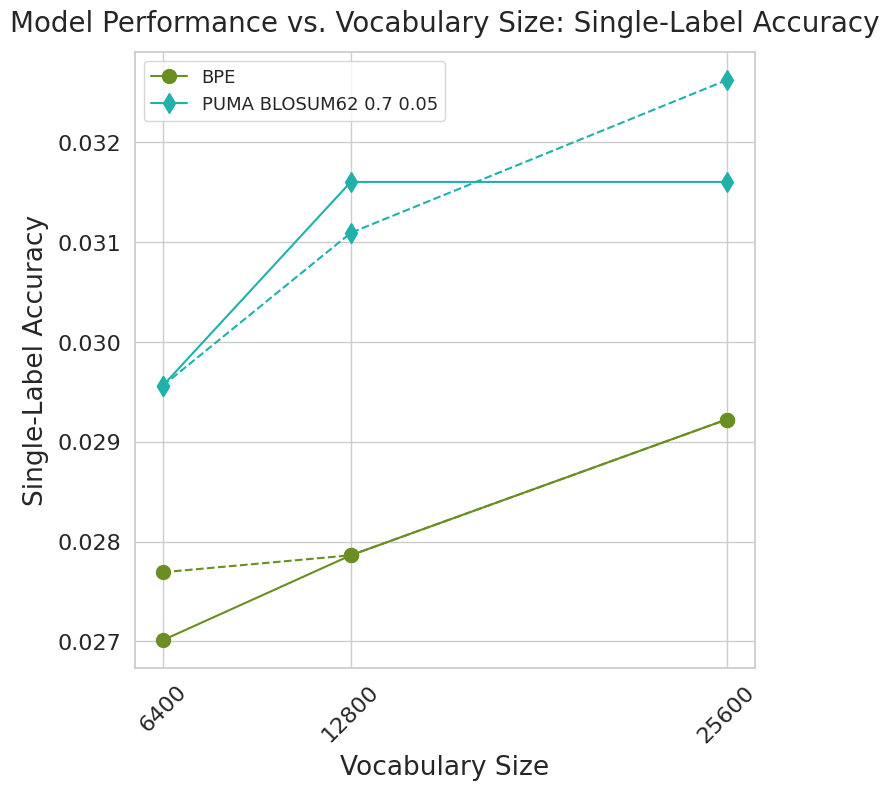

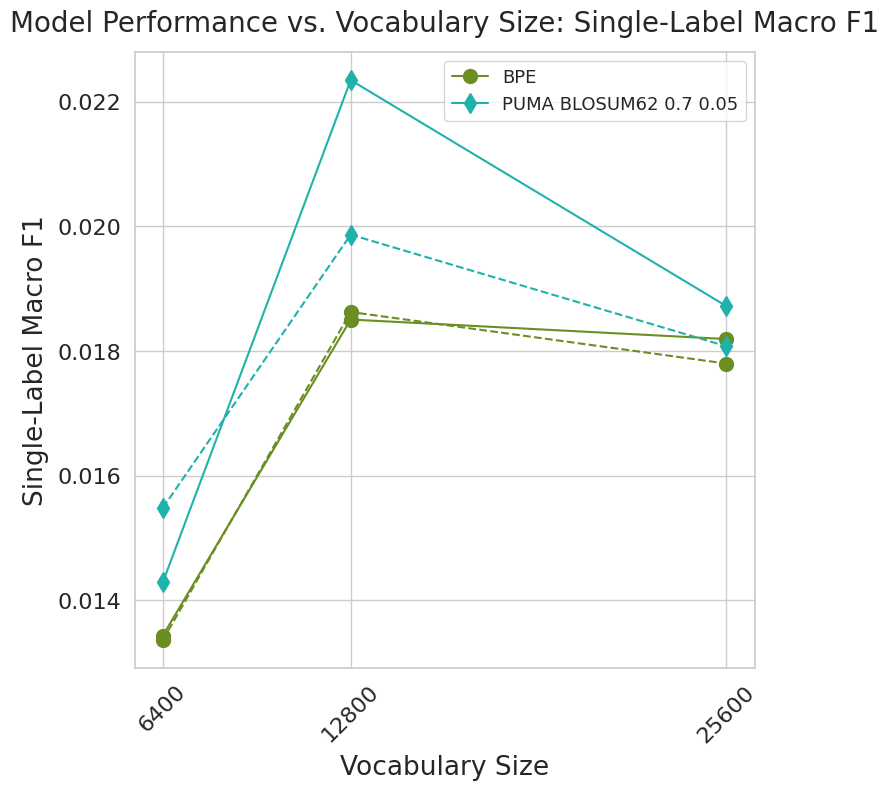

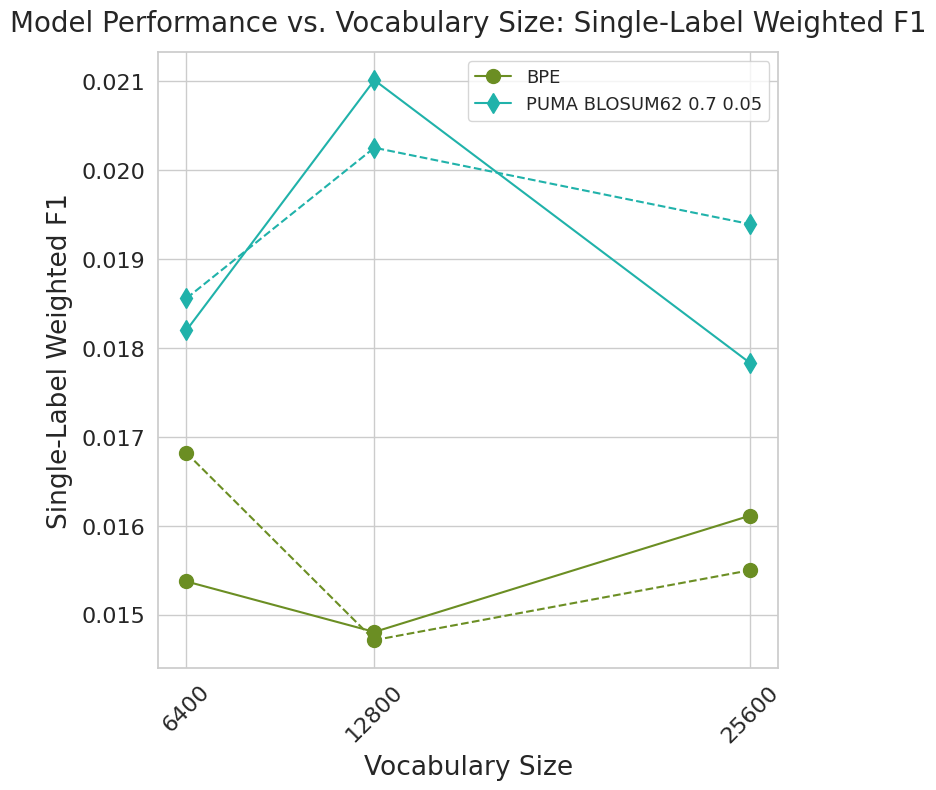

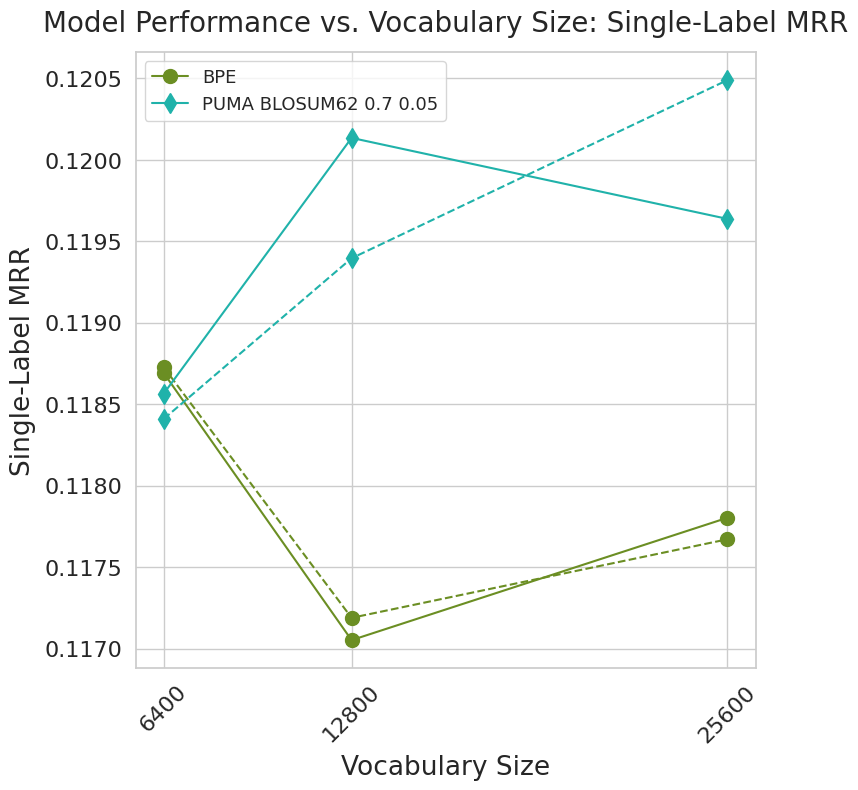

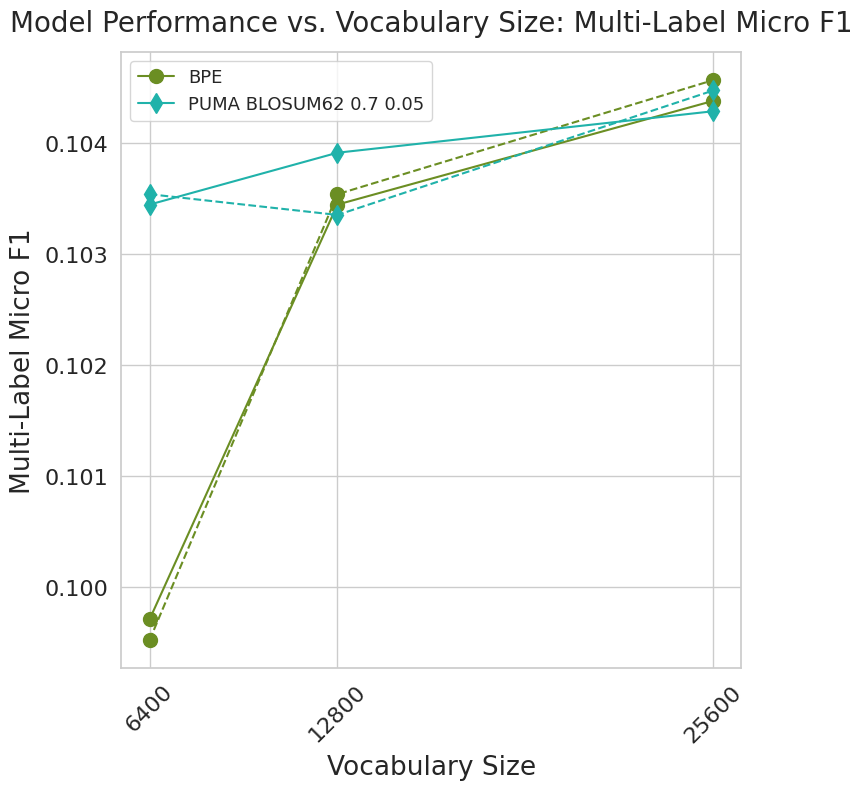

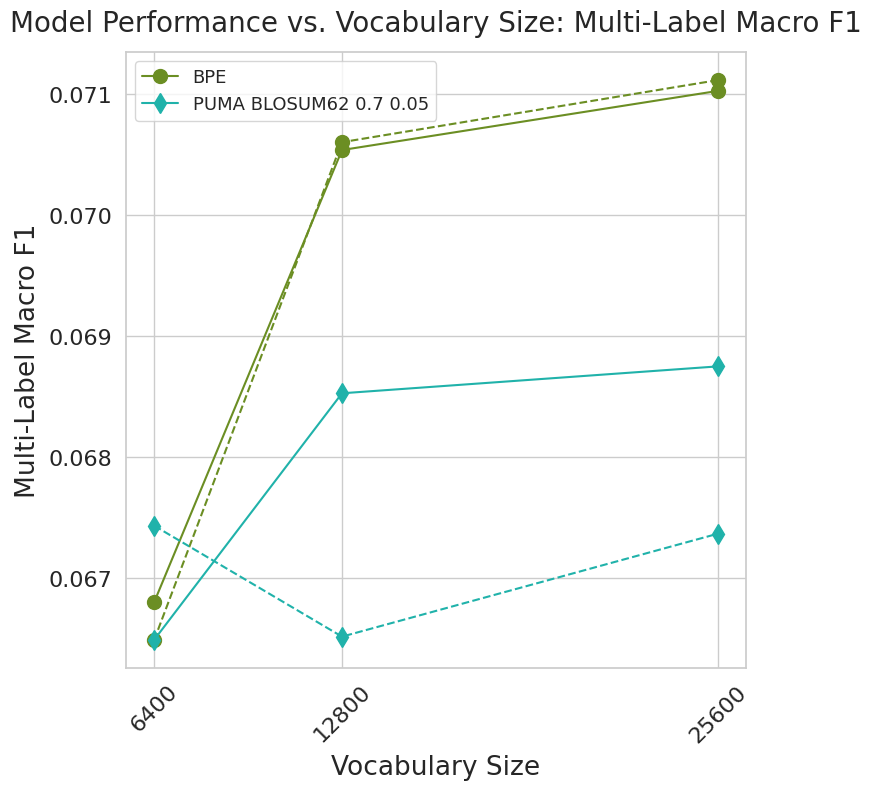

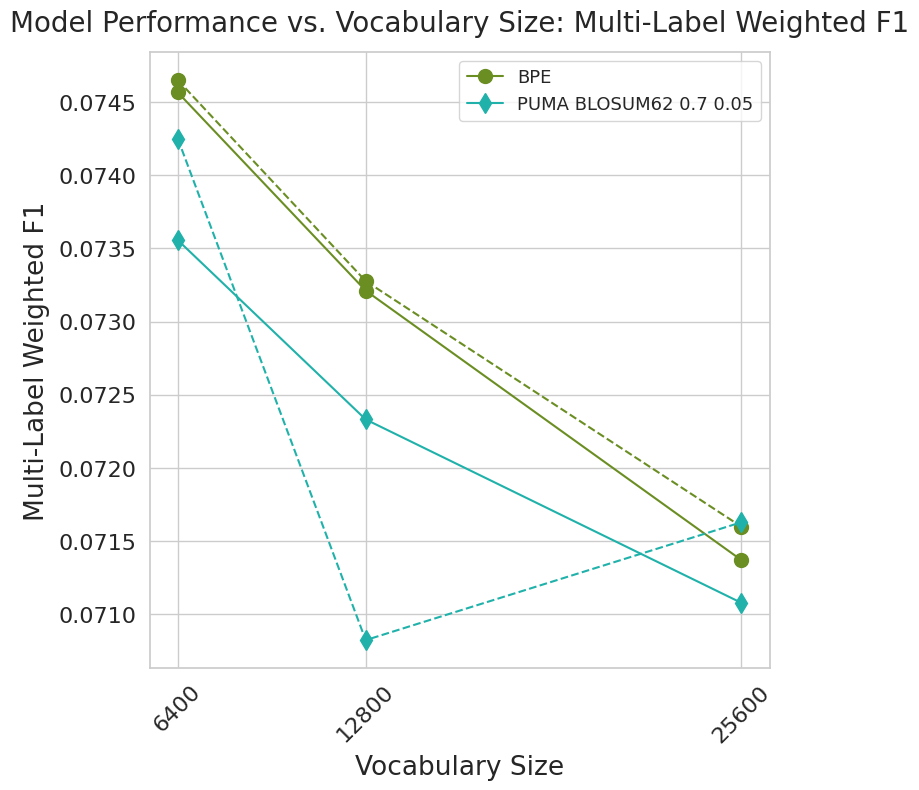

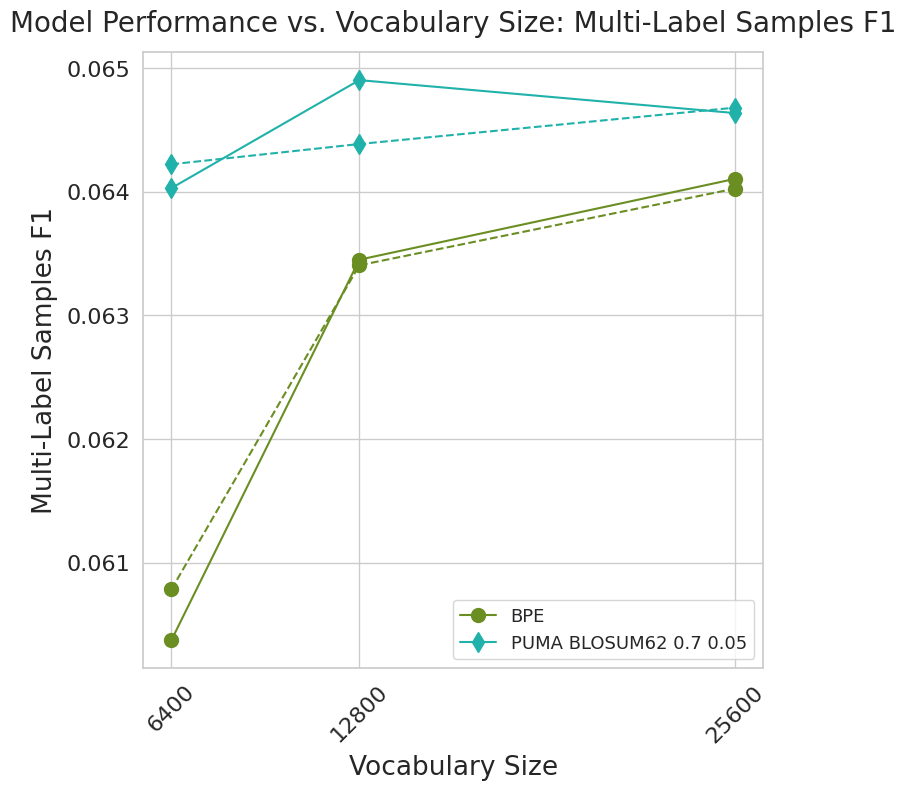

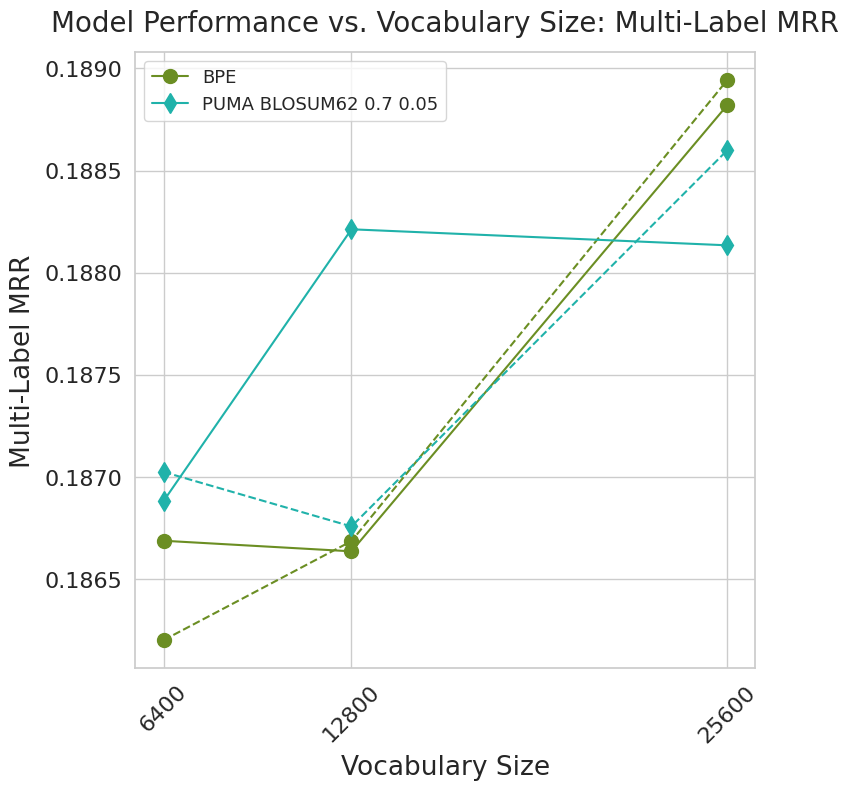

,Tokenizer,Model,Single-Label Accuracy,Single-Label Macro F1,Single-Label Weighted F1,Single-Label MRR,Multi-Label Micro F1,Multi-Label Macro F1,Multi-Label Weighted F1,Multi-Label Samples F1,Multi-Label MRR
0,BPE 6400,Standard BERTopic,0.027013,0.013434,0.015374,0.118691,0.099710,0.066800,0.074565,0.060375,0.186687
1,BPE 6400,Graph-Aware BERTopic,0.027693,0.013362,0.016820,0.118727,0.099523,0.066488,0.074649,0.060785,0.186201
2,BPE 12800,Standard BERTopic,0.027863,0.018505,0.014806,0.117052,0.103448,0.070536,0.073211,0.063451,0.186635
3,BPE 12800,Graph-Aware BERTopic,0.027863,0.018626,0.014714,0.117189,0.103542,0.070601,0.073277,0.063405,0.186685
4,BPE 25600,Standard BERTopic,0.029222,0.018192,0.016115,0.117803,0.104383,0.071024,0.071371,0.064104,0.188820
5,BPE 25600,Graph-Aware BERTopic,0.029222,0.017799,0.015500,0.117671,0.104570,0.071113,0.071599,0.064025,0.188943
6,PUMA blosum62 0.7 0.05 6400,Standard BERTopic,0.029562,0.014289,0.018201,0.118565,0.103448,0.066490,0.073556,0.064030,0.186882
7,PUMA blosum62 0.7 0.05 6400,Graph-Aware BERTopic,0.029562,0.015482,0.018560,0.118409,0.103542,0.067433,0.074249,0.064222,0.187024
8,PUMA blosum62 0.7 0.05 12800,Standard BERTopic,0.031600,0.022346,0.021015,0.120134,0.103916,0.068527,0.072332,0.064902,0.188212
9,PUMA blosum62 0.7 0.05 12800,Graph-Aware BERTopic,0.031091,0.019867,0.020254,0.119396,0.103355,0.066516,0.070824,0.064386,0.186757


In [364]:
# df = df_protein_go.copy()
df = df_protein_go[df_protein_go['go_aspect'] == 'cellular_component'].reset_index(drop=True).copy()
df_train, df_test = split_data(df)

tokenizer_cols = list(tokenizer_list.keys())
go_col = 'go_name'
token_len_thr = 4
lambda_smooth = 1.0
alpha = 0.2
beta = 0.5
theta = 0.8

df_results = compare_tokenization_methods(df_train, df_test, tokenizer_cols[:6], go_col, token_len_thr, lambda_smooth, alpha, beta, theta)
df_results